## Introduction

Ce noteboook est le ***troisième*** d'une série où je regarde des grands jeux de données, et dans chaque cas j'utilise un outil différent pour effectuer la même analyse sur le même jeu de données.

Cette fois-ci j'utilise **PySpark**, l'API Python pour **Apache Spark**, un cadre open source pour l'informatique distribuée et un ensemble de bibliothèques pour le traitement des données à grande échelle et en temps réel. On peut trouver chaque notebook dans la série dans mon [répertoire Github](https://github.com/jlad26/london-smart-energy), y compris:
1. Pandas chunksize
1. Bibliothèque Dask
3. PySpark

Il y a un peu plus d'explication dans le premier notebook (Pandas chunksize) par rapport à l'approche générale de l'analyse. Dans les autres notebooks je me concentre plus sur les éléments spécifiques à l'outil que j'utilise.

## Description du jeu de données

On se servira du jeu de données des [Données de consommation d'énergie des résidences muni de SmartMeter à Londres](https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households), qui contient, selon le site web:
>Des relevés de consommation d'énergie pour un échantillon de 5 567 résidences à Londres qui ont participé au projet de Low Carbon London (géré par UK Power Networks) entre novembre 2011 et février 2014.

Les résidences étaient divisées en deux groupes:
- Celles qui ont reçu des tarifs d'énergie Dynamic Time of Use (dTou) (décrit "Haut", "Moyen", ou "Bas") la veille du jour où le prix allait être appliqué.
- Celles qui étaient soumises au tarif Standard.

Un but du projet était d'évaluer si la connaisance du prix de l'énergie changerait le comportement par rapport à la consommation d'énergie.

## Résultats

<img src="images/result1-no-dupes.png" width="100%"/>

Les résultats montrent la variation saisonnière attendue et une différence nette entre les deux groupes, qui suggère qu'une connaissance du prix d'énergie aide à réduire la consommation de l'énergie.

Le reste du notebook montre comment le diagramme était produit des données brutes.

## Introduction à PySpark et à Apache Spark

Quelques phrases - en anglais (désolé!) - pour expliquer les principes fondamentaux (copié d'[ici](https://www.dominodatalab.com/data-science-dictionary/pyspark#:~:text=PySpark%20is%20the%20Python%20API,more%20scalable%20analyses%20and%20pipelines.)).
>Apache Spark is basically a computational engine that works with huge sets of data by processing them in parallel and batch systems. Spark is written in Scala, and PySpark was released to support the collaboration of Spark and Python. In addition to providing an API for Spark, PySpark helps you interface with Resilient Distributed Datasets (RDDs) by leveraging the Py4j library.
>
>The key data type used in PySpark is the Spark dataframe. This object can be thought of as a table distributed across a cluster, and has functionality that is similar to dataframes in R and Pandas. If you want to do distributed computation using PySpark, then you’ll need to perform operations on Spark dataframes and not other Python data types.
>
>One of the key differences between Pandas and Spark dataframes is eager versus lazy execution. In PySpark, operations are delayed until a result is actually requested in the pipeline. For example, you can specify operations for loading a data set from Amazon S3 and applying a number of transformations to the dataframe, but these operations won’t be applied immediately. Instead, a graph of transformations is recorded, and once the data are actually needed, for example when writing the results back to S3, then the transformations are applied as a single pipeline operation. This approach is used to avoid pulling the full dataframe into memory, and enables more effective processing across a cluster of machines. With Pandas dataframes, everything is pulled into memory, and every Pandas operation is applied immediately.

En résumé, on va utiliser Pyspark à peu près de la même manière qu'on a utilisé la bibliothèque Dask dans le sens où:
- On peut utiliser plusieurs CPUs dans un seul ordinateur au lieu d'un seul CPU.
- Les opérations sont "paresseuses", qui veut dire qu'ils exécutent seulement lorsqu'il est nécessaire.
- On se sert des RDDs (Resilient Distributed Datasets) au lieu d'un dataframe Pandas pour manipuler les données.

## Installation

Pour installer et configurer PySpark j'ai suivi les consignes [ici](https://www.sicara.fr/blog-technique/2017-05-02-get-started-pyspark-jupyter-notebook-3-minutes), en utilisant la deuxième méthode (FindSpark).

## Accéder les données

On peut télécharger les données sous forme de fichier zip qui contient un fichier csv de 167 million lignes. Si la commande `curl` ne fonctionne pas (il faudra un certains temps puisque c'est un fichier de 800MB), vous pouvez télécharger le fichier [ici](https://data.london.gov.uk/download/smartmeter-energy-use-data-in-london-households/3527bf39-d93e-4071-8451-df2ade1ea4f2/LCL-FullData.zip) et le mettre dans le dossier `data` qui se trouve dans le dossier où ce notebook est sauvegardé.

In [ ]:
!curl "https://data.london.gov.uk/download/smartmeter-energy-use-data-in-london-households/3527bf39-d93e-4071-8451-df2ade1ea4f2/LCL-FullData.zip" --location --create-dirs -o "data/LCL-FullData.zip"

Ensuite on décompresse les données. Il faudra peut-être un certain temps! Vous pouvez également le décompresser manuellement en utilisant un autre logiciel de décompression. Assurez-vous simplement que vous mettez le fichier décompressé dans un dossier qui s'appelle `data` dans le dossier où votre notebook est sauvegardé.

In [ ]:
!unzip "data/LCL-FullData.zip" -d "data"

## Examiner les données

In [1]:
import findspark
findspark.init()
import pyspark

In [2]:
import pandas as pd

D'abord il faut créer un `SparkContext`.

In [3]:
sc = pyspark.SparkContext(appName="LSE")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/27 10:05:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/06/27 10:05:49 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Maintenant chargeons les données dans un RDD qu'on nommera `raw_data`.

In [4]:
raw_data = sc.textFile("data/CC_LCL-FullData.csv")

In [5]:
raw_data.take(15)

['LCLid,stdorToU,DateTime,KWH/hh (per half hour) ',
 'MAC000002,Std,2012-10-12 00:30:00.0000000, 0 ',
 'MAC000002,Std,2012-10-12 01:00:00.0000000, 0 ',
 'MAC000002,Std,2012-10-12 01:30:00.0000000, 0 ',
 'MAC000002,Std,2012-10-12 02:00:00.0000000, 0 ',
 'MAC000002,Std,2012-10-12 02:30:00.0000000, 0 ',
 'MAC000002,Std,2012-10-12 03:00:00.0000000, 0 ',
 'MAC000002,Std,2012-10-12 03:30:00.0000000, 0 ',
 'MAC000002,Std,2012-10-12 04:00:00.0000000, 0 ',
 'MAC000002,Std,2012-10-12 04:30:00.0000000, 0 ',
 'MAC000002,Std,2012-10-12 05:00:00.0000000, 0 ',
 'MAC000002,Std,2012-10-12 05:30:00.0000000, 0 ',
 'MAC000002,Std,2012-10-12 06:00:00.0000000, 0 ',
 'MAC000002,Std,2012-10-12 06:30:00.0000000, 0 ',
 'MAC000002,Std,2012-10-12 07:00:00.0000000, 0 ']

Veuillez noter que nos données sont sous forme d'une liste, et que chaque élément est une seule chaíne qui représente une ligne des données.

On peut voir aussi que nos données sont divisées en 255 partitions, en utilisant la méthode `getNumPartitions`.

In [6]:
raw_data.getNumPartitions()

255

Supprimons les en-têtes des données parce qu'on voudra appliquer des fonctions à notre RDD et on voudra les appliquer aux données, et pas aux en-têtes.

On utilise la méthode `filter` pour supprimer la ligne.

In [7]:
header = raw_data.first()
full_data = raw_data.filter(lambda x : x != header)
full_data.take(15)

['MAC000002,Std,2012-10-12 00:30:00.0000000, 0 ',
 'MAC000002,Std,2012-10-12 01:00:00.0000000, 0 ',
 'MAC000002,Std,2012-10-12 01:30:00.0000000, 0 ',
 'MAC000002,Std,2012-10-12 02:00:00.0000000, 0 ',
 'MAC000002,Std,2012-10-12 02:30:00.0000000, 0 ',
 'MAC000002,Std,2012-10-12 03:00:00.0000000, 0 ',
 'MAC000002,Std,2012-10-12 03:30:00.0000000, 0 ',
 'MAC000002,Std,2012-10-12 04:00:00.0000000, 0 ',
 'MAC000002,Std,2012-10-12 04:30:00.0000000, 0 ',
 'MAC000002,Std,2012-10-12 05:00:00.0000000, 0 ',
 'MAC000002,Std,2012-10-12 05:30:00.0000000, 0 ',
 'MAC000002,Std,2012-10-12 06:00:00.0000000, 0 ',
 'MAC000002,Std,2012-10-12 06:30:00.0000000, 0 ',
 'MAC000002,Std,2012-10-12 07:00:00.0000000, 0 ',
 'MAC000002,Std,2012-10-12 07:30:00.0000000, 0 ']

## Nettoyer les données

Travillons sur une petite partie du jeu de données (10 000 lignes) pour créer et tester chaque étape de traitement.

In [8]:
test_data = sc.parallelize(full_data.take(10000))
test_data.getNumPartitions()

8

D'abord supprimons les doublons s'il y en a.

In [9]:
test_data_no_dupes = test_data.distinct()

Comme attendu, l'opération n'a pas été exécutée encore parce qu'on est en mode d'exécution "paresseuse". Pour voir les résultats de l'opération il faut utiliser la méthode `collect`.

In [10]:
len(test_data_no_dupes.collect())

9993

On sait que cela a marché parce que 7 doublons ont été supprimés. Maintenant on développe le traitement.

On va utiliser la méthode `map` pour traiter les données. La première étape consiste à repartitionner chaque chaîne (qui représente une ligne) sous forme de liste.

In [11]:
def split_line_into_list(x):
    '''
    Split single string of line in csv format into values corresponding to columns
    '''
    return x.split(",")

In [12]:
split_test_data = test_data_no_dupes.map(split_line_into_list)

In [13]:
split_test_data.collect()[:15]

[['MAC000002', 'Std', '2012-10-12 17:00:00.0000000', ' 0.493 '],
 ['MAC000002', 'Std', '2012-10-12 20:00:00.0000000', ' 0.198 '],
 ['MAC000002', 'Std', '2012-10-13 01:00:00.0000000', ' 0.275 '],
 ['MAC000002', 'Std', '2012-10-13 02:00:00.0000000', ' 0.211 '],
 ['MAC000002', 'Std', '2012-10-13 03:30:00.0000000', ' 0.119 '],
 ['MAC000002', 'Std', '2012-10-13 09:30:00.0000000', ' 0.191 '],
 ['MAC000002', 'Std', '2012-10-13 12:00:00.0000000', ' 0.076 '],
 ['MAC000002', 'Std', '2012-10-13 12:30:00.0000000', ' 0.133 '],
 ['MAC000002', 'Std', '2012-10-13 13:30:00.0000000', ' 0.133 '],
 ['MAC000002', 'Std', '2012-10-13 16:30:00.0000000', ' 0.184 '],
 ['MAC000002', 'Std', '2012-10-13 19:30:00.0000000', ' 0.278 '],
 ['MAC000002', 'Std', '2012-10-13 22:30:00.0000000', ' 0.188 '],
 ['MAC000002', 'Std', '2012-10-14 00:00:00.0000000', ' 0.262 '],
 ['MAC000002', 'Std', '2012-10-14 10:00:00.0000000', ' 0.524 '],
 ['MAC000002', 'Std', '2012-10-14 12:30:00.0000000', ' 0.22 ']]

Maintenant on peut effectuer les opérations de nettoyage (les mêmes opérations qu'on trouve dans les autres notebooks de la série):
1. Convertir les valeurs kWh en valeurs numériques
1. Convertir les données de type horodatage en forme de date, prêt pour le regoupement

In [14]:
def convert_kwh_data_to_numeric(x):
    '''
    Convert the kWh value from string to float
    '''
    x[3] = float(x[3])
    return x

In [15]:
numeric_kwh_test_data = split_test_data.map(convert_kwh_data_to_numeric)
numeric_kwh_test_data.collect()

22/06/27 10:06:00 ERROR Executor: Exception in task 2.0 in stage 9.0 (TID 30)
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 619, in main
    process()
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 611, in process
    serializer.dump_stream(out_iter, outfile)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/spark/python/lib/pyspark.zip/pyspark/util.py", line 74, in wrapper
    return f(*args, **kwargs)
  File "/tmp/ipykernel_91458/95641023.py", line 5, in convert_kwh_data_to_numeric
ValueError: could not convert string to float: 'Null'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:555)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:713)
	at org.apache.spark.api.python.PythonR

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 9.0 failed 1 times, most recent failure: Lost task 2.0 in stage 9.0 (TID 30) (localhost executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 619, in main
    process()
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 611, in process
    serializer.dump_stream(out_iter, outfile)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/spark/python/lib/pyspark.zip/pyspark/util.py", line 74, in wrapper
    return f(*args, **kwargs)
  File "/tmp/ipykernel_91458/95641023.py", line 5, in convert_kwh_data_to_numeric
ValueError: could not convert string to float: 'Null'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:555)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:713)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:695)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:508)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1030)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2254)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2454)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2402)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2402)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1160)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2642)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2584)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2573)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2235)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2254)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2279)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 619, in main
    process()
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 611, in process
    serializer.dump_stream(out_iter, outfile)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/spark/python/lib/pyspark.zip/pyspark/util.py", line 74, in wrapper
    return f(*args, **kwargs)
  File "/tmp/ipykernel_91458/95641023.py", line 5, in convert_kwh_data_to_numeric
ValueError: could not convert string to float: 'Null'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:555)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:713)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:695)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:508)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1030)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2254)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


Le message d'erreur nous dit que une valeur `"Null"` de type chaîne empêche la transformation. Donc supprimons ces lignes d'abord avec la méthode `filter`.

In [16]:
def remove_nulls(x):
    return x[3] != 'Null'

In [17]:
filtered_test_data = split_test_data.filter(remove_nulls)

In [18]:
numeric_kwh_test_data = filtered_test_data.map(convert_kwh_data_to_numeric)
numeric_kwh_test_data.collect()[:15]

[['MAC000002', 'Std', '2012-10-12 17:00:00.0000000', 0.493],
 ['MAC000002', 'Std', '2012-10-12 20:00:00.0000000', 0.198],
 ['MAC000002', 'Std', '2012-10-13 01:00:00.0000000', 0.275],
 ['MAC000002', 'Std', '2012-10-13 02:00:00.0000000', 0.211],
 ['MAC000002', 'Std', '2012-10-13 03:30:00.0000000', 0.119],
 ['MAC000002', 'Std', '2012-10-13 09:30:00.0000000', 0.191],
 ['MAC000002', 'Std', '2012-10-13 12:00:00.0000000', 0.076],
 ['MAC000002', 'Std', '2012-10-13 12:30:00.0000000', 0.133],
 ['MAC000002', 'Std', '2012-10-13 13:30:00.0000000', 0.133],
 ['MAC000002', 'Std', '2012-10-13 16:30:00.0000000', 0.184],
 ['MAC000002', 'Std', '2012-10-13 19:30:00.0000000', 0.278],
 ['MAC000002', 'Std', '2012-10-13 22:30:00.0000000', 0.188],
 ['MAC000002', 'Std', '2012-10-14 00:00:00.0000000', 0.262],
 ['MAC000002', 'Std', '2012-10-14 10:00:00.0000000', 0.524],
 ['MAC000002', 'Std', '2012-10-14 12:30:00.0000000', 0.22]]

Tout marche comme il faut maintenant. Maintenant on effectue la conversion de date.

In [19]:
def convert_timestamp_to_date_string(x):
    '''
    Convert the timestamp into a date string
    '''
    x[2] = x[2].split(" ")[0]
    return x

In [20]:
cleaned_test_data = numeric_kwh_test_data.map(convert_timestamp_to_date_string)
cleaned_test_data.collect()[:15]

[['MAC000002', 'Std', '2012-10-12', 0.493],
 ['MAC000002', 'Std', '2012-10-12', 0.198],
 ['MAC000002', 'Std', '2012-10-13', 0.275],
 ['MAC000002', 'Std', '2012-10-13', 0.211],
 ['MAC000002', 'Std', '2012-10-13', 0.119],
 ['MAC000002', 'Std', '2012-10-13', 0.191],
 ['MAC000002', 'Std', '2012-10-13', 0.076],
 ['MAC000002', 'Std', '2012-10-13', 0.133],
 ['MAC000002', 'Std', '2012-10-13', 0.133],
 ['MAC000002', 'Std', '2012-10-13', 0.184],
 ['MAC000002', 'Std', '2012-10-13', 0.278],
 ['MAC000002', 'Std', '2012-10-13', 0.188],
 ['MAC000002', 'Std', '2012-10-14', 0.262],
 ['MAC000002', 'Std', '2012-10-14', 0.524],
 ['MAC000002', 'Std', '2012-10-14', 0.22]]

## Agréger les données

Pour agréger on va utiliser la méthode `reduceByKey`. Pour faire cela il faut restructurer nos données en tuples de forme `(cle, donnees_a_reduire)`. Dans ce cas-ci on veut que la clé soit une clé combinée de date, résidence et type de tarif, et que les données soient les valeurs de kWh. Donc ca veut dire que la clé sera un tuple aussi.

In [21]:
def create_keyed_kwh_data(x):
    return ( (x[0], x[1], x[2]), x[3] )

In [22]:
keyed_kwh_data = cleaned_test_data.map(create_keyed_kwh_data)
keyed_kwh_data.collect()[:15]

[(('MAC000002', 'Std', '2012-10-12'), 0.493),
 (('MAC000002', 'Std', '2012-10-12'), 0.198),
 (('MAC000002', 'Std', '2012-10-13'), 0.275),
 (('MAC000002', 'Std', '2012-10-13'), 0.211),
 (('MAC000002', 'Std', '2012-10-13'), 0.119),
 (('MAC000002', 'Std', '2012-10-13'), 0.191),
 (('MAC000002', 'Std', '2012-10-13'), 0.076),
 (('MAC000002', 'Std', '2012-10-13'), 0.133),
 (('MAC000002', 'Std', '2012-10-13'), 0.133),
 (('MAC000002', 'Std', '2012-10-13'), 0.184),
 (('MAC000002', 'Std', '2012-10-13'), 0.278),
 (('MAC000002', 'Std', '2012-10-13'), 0.188),
 (('MAC000002', 'Std', '2012-10-14'), 0.262),
 (('MAC000002', 'Std', '2012-10-14'), 0.524),
 (('MAC000002', 'Std', '2012-10-14'), 0.22)]

Maintenant on utilise `reduceByKey` pour additioner les valeurs de kWh.

In [23]:
aggregated_test_data = keyed_kwh_data.reduceByKey(lambda x, y : x + y)
aggregated_test_data.collect()[:15]

[(('MAC000002', 'Std', '2012-10-12'), 7.098000000000001),
 (('MAC000002', 'Std', '2012-10-18'), 10.750999999999998),
 (('MAC000002', 'Std', '2012-10-24'), 15.5370001),
 (('MAC000002', 'Std', '2012-10-25'), 13.128),
 (('MAC000002', 'Std', '2012-11-01'), 12.209),
 (('MAC000002', 'Std', '2012-11-03'), 14.347),
 (('MAC000002', 'Std', '2012-11-10'), 13.245000000000001),
 (('MAC000002', 'Std', '2012-11-12'), 12.321000000000002),
 (('MAC000002', 'Std', '2012-11-13'), 10.264000000000001),
 (('MAC000002', 'Std', '2012-11-22'), 9.44),
 (('MAC000002', 'Std', '2012-12-08'), 13.441999999999998),
 (('MAC000002', 'Std', '2012-12-28'), 11.157),
 (('MAC000002', 'Std', '2013-01-01'), 10.8),
 (('MAC000002', 'Std', '2013-01-06'), 10.293000000000001),
 (('MAC000002', 'Std', '2013-01-11'), 10.978999899999996)]

In [24]:
aggregated_test_data_table = aggregated_test_data.map(lambda x : (x[0][0], x[0][1], x[0][2], x[1]))
aggregated_test_data_table.collect()[:15]

[('MAC000002', 'Std', '2012-10-12', 7.098000000000001),
 ('MAC000002', 'Std', '2012-10-18', 10.750999999999998),
 ('MAC000002', 'Std', '2012-10-24', 15.5370001),
 ('MAC000002', 'Std', '2012-10-25', 13.128),
 ('MAC000002', 'Std', '2012-11-01', 12.209),
 ('MAC000002', 'Std', '2012-11-03', 14.347),
 ('MAC000002', 'Std', '2012-11-10', 13.245000000000001),
 ('MAC000002', 'Std', '2012-11-12', 12.321000000000002),
 ('MAC000002', 'Std', '2012-11-13', 10.264000000000001),
 ('MAC000002', 'Std', '2012-11-22', 9.44),
 ('MAC000002', 'Std', '2012-12-08', 13.441999999999998),
 ('MAC000002', 'Std', '2012-12-28', 11.157),
 ('MAC000002', 'Std', '2013-01-01', 10.8),
 ('MAC000002', 'Std', '2013-01-06', 10.293000000000001),
 ('MAC000002', 'Std', '2013-01-11', 10.978999899999996)]

Et pour terminer on convertit le résultat en dataframe Pandas.

In [25]:
test_summary_daily = pd.DataFrame(
    data = aggregated_test_data_table.collect(),
    columns = ['Household ID', 'Tariff Type', 'Date', 'kWh']
)
test_summary_daily

,Household ID,Tariff Type,Date,kWh
0,MAC000002,Std,2012-10-12,7.098
1,MAC000002,Std,2012-10-18,10.751
2,MAC000002,Std,2012-10-24,15.537
3,MAC000002,Std,2012-10-25,13.128
4,MAC000002,Std,2012-11-01,12.209
...,...,...,...,...
205,MAC000002,Std,2013-04-12,12.563
206,MAC000002,Std,2013-04-16,10.940
207,MAC000002,Std,2013-04-25,9.481
208,MAC000002,Std,2013-04-27,9.625


## Traiter le jeu de données complet

Maintenant on peut appliquer les mêmes méthodes aux données complètes. Veuillez noter que rien ne va se passer jusqu'à ce qu'on appelle `collect`.

Quand on peut, on amalgame nos fonctions dans une seule fonction qu'on appellera avec `map`.

In [26]:
def process_data(x):
    x = convert_kwh_data_to_numeric(x)
    x = convert_timestamp_to_date_string(x)
    x = create_keyed_kwh_data(x)
    return x

In [27]:
aggregated_data_table_rdd = (
    full_data.distinct()
    .map(split_line_into_list)
    .filter(remove_nulls)
    .map(process_data)
    .reduceByKey(lambda x, y : x + y)
    .map(lambda x : (x[0][0], x[0][1], x[0][2], x[1]))
)

In [28]:
aggregrated_data_table = aggregated_data_table_rdd.collect()

Veuillez noter que quand nous appellons `collect` PySpark affiche une barre de progrès utile (exemple ci-dessus):

<img src="images/PySpark progress.png" width="100%"/>

Et maintenant qu'on a réduit nos données on peut les convertir en un seul dataframe Pandas.

In [29]:
daily_summary = pd.DataFrame(
    data = aggregrated_data_table,
    columns = ['Household ID', 'Tariff Type', 'Date', 'kWh']
)

In [30]:
daily_summary

,Household ID,Tariff Type,Date,kWh
0,MAC000004,Std,2012-07-22,1.498
1,MAC000007,Std,2013-06-12,6.837
2,MAC000008,Std,2013-04-02,22.690
3,MAC000009,Std,2013-07-06,6.291
4,MAC000012,Std,2013-04-28,1.269
...,...,...,...,...
3510398,MAC002748,Std,2014-02-28,0.115
3510399,MAC003631,Std,2014-02-28,0.068
3510400,MAC005337,Std,2014-02-28,1.325
3510401,MAC002930,ToU,2014-02-28,0.118


A partir d'ici, le reste de ce notebook contient à peu près le même traitement que tous les autres notebooks dans la série.

## Sauvegarder les données agrégées

Maintentant qu'on a ramené les données à environ 3 millions lignes on devrait pouvoir les contenir dans un seul dataframe. Il vaut mieux les sauvegarder pour qu'on n'ait pas besoin de réexecuter l'agrégation chaque fois qu'on veut traiter les données.

On va le sauvegarder comme fichier compressé gz - pandas reconnait automatiquement le type de fichier quand on précise l'extension.

In [31]:
daily_summary.to_csv("data/daily-summary-data.gz", index=False)

## Analyser les données

In [32]:
saved_daily_summary = pd.read_csv("data/daily-summary-data.gz")

In [33]:
saved_daily_summary

,Household ID,Tariff Type,Date,kWh
0,MAC000004,Std,2012-07-22,1.498
1,MAC000007,Std,2013-06-12,6.837
2,MAC000008,Std,2013-04-02,22.690
3,MAC000009,Std,2013-07-06,6.291
4,MAC000012,Std,2013-04-28,1.269
...,...,...,...,...
3510398,MAC002748,Std,2014-02-28,0.115
3510399,MAC003631,Std,2014-02-28,0.068
3510400,MAC005337,Std,2014-02-28,1.325
3510401,MAC002930,ToU,2014-02-28,0.118


Par intérêt examinons la couverture des données. D'abord on réorganise pour avoir les résidences en colonne et les date en ligne.

In [34]:
summary_table = saved_daily_summary.pivot_table(
    'kWh',
    index='Date',
    columns='Household ID',
    aggfunc='sum'
)

Ensuite on peut afficher où on a des données (noir) et où on n'en a pas (blanc).

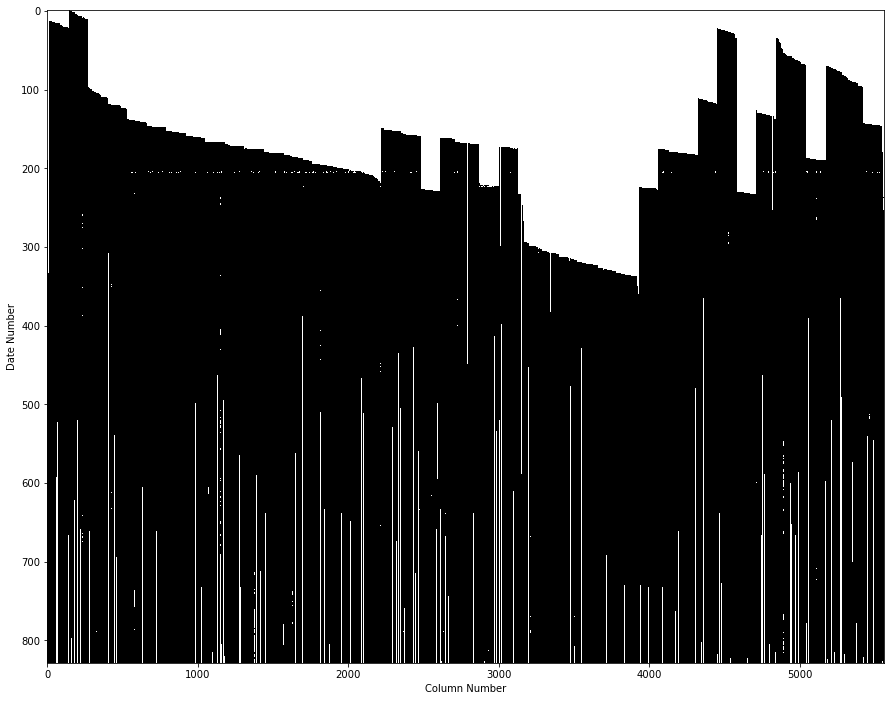

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))
plt.imshow(summary_table.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Date Number");

Malgré une couverture un peu lacunaire, calculer par tarif sur toutes les résidences par jour devrait nous donner une comparaison utile.

In [36]:
daily_mean_by_tariff_type = saved_daily_summary.pivot_table(
    'kWh',
    index='Date',
    columns='Tariff Type',
    aggfunc='mean'
)
daily_mean_by_tariff_type

Tariff Type,Std,ToU
Date,,
2011-11-23,7.430000,4.327500
2011-11-24,8.998333,6.111750
2011-11-25,10.102885,6.886333
2011-11-26,10.706257,7.709500
2011-11-27,11.371486,7.813500
...,...,...
2014-02-24,10.580187,9.759439
2014-02-25,10.453365,9.683862
2014-02-26,10.329026,9.716652


Finalement on peut tracer les deux groupes de données. Le traçage marche mieux si on convertit la date de type `string` en type `datetime`.

In [37]:
daily_mean_by_tariff_type.index = pd.to_datetime(daily_mean_by_tariff_type.index)

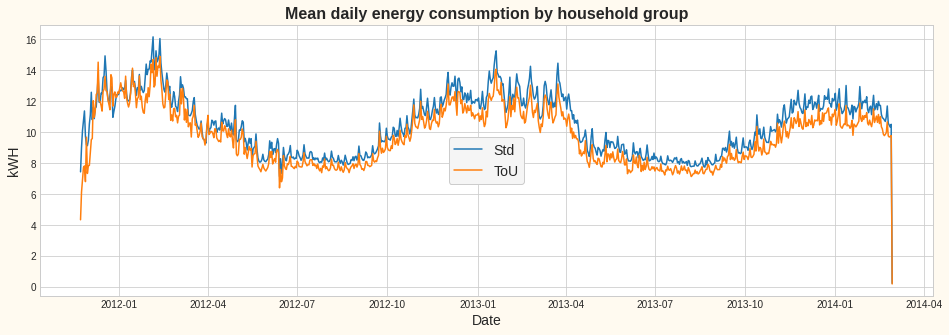

In [38]:
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(16, 5), facecolor='floralwhite')
for tariff in daily_mean_by_tariff_type.columns.to_list():
    plt.plot(
        daily_mean_by_tariff_type.index.values,
        daily_mean_by_tariff_type[tariff],
        label = tariff
    )

plt.legend(loc='center', frameon=True, facecolor='whitesmoke', framealpha=1, fontsize=14)
plt.title(
    'Mean daily energy consumption by household group',
    fontdict = {'fontsize' : 16, 'fontweight' : 'bold'}
)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('kWH', fontsize = 14)
plt.show()

On dirait que la variation est saisonnière qui n'est pas étonnant vu la demande d'énergie de chauffage.

On dirait aussi qu'il y a une différence entre les deux groupes: le groupe ToU a l'air de consommer moins, mais l'affichage est trop granulaire pour voir bien. Agégeons encore une fois, cette fois-ci par mois.

In [39]:
daily_mean_by_tariff_type

Tariff Type,Std,ToU
Date,,
2011-11-23,7.430000,4.327500
2011-11-24,8.998333,6.111750
2011-11-25,10.102885,6.886333
2011-11-26,10.706257,7.709500
2011-11-27,11.371486,7.813500
...,...,...
2014-02-24,10.580187,9.759439
2014-02-25,10.453365,9.683862
2014-02-26,10.329026,9.716652


On voit que les données commencent au cours de novembre 2011, donc on commencera le 1 décembre. On dirait que les données terminent parfaitement à la fin de février, mais la dernière valeur est suspecte puisqu'elle est très basse comparé aux autres. Il paraît probable que les données ont terminé au cours de la dernière journée, donc on finira à la fin de janvier. Peut-être qu'on a le même problème ailleurs dans les données, mais l'effet ne devrait pas être énorme parce que dans le pire des cas la consommation mensuelle d'une résidence sera réduite par deux journées (une au début et une à la fin).

In [40]:
monthly_mean_by_tariff_type = daily_mean_by_tariff_type['2011-12-01' : '2014-01-31'].resample('M').sum()
monthly_mean_by_tariff_type

Tariff Type,Std,ToU
Date,,
2011-12-31,377.218580,365.145947
2012-01-31,401.511261,386.016403
2012-02-29,395.065321,368.475150
2012-03-31,349.153085,330.900633
2012-04-30,314.173857,296.903425
2012-05-31,281.666428,263.694338
2012-06-30,257.204029,238.417505
2012-07-31,260.231952,244.641359
2012-08-31,253.939017,238.904096


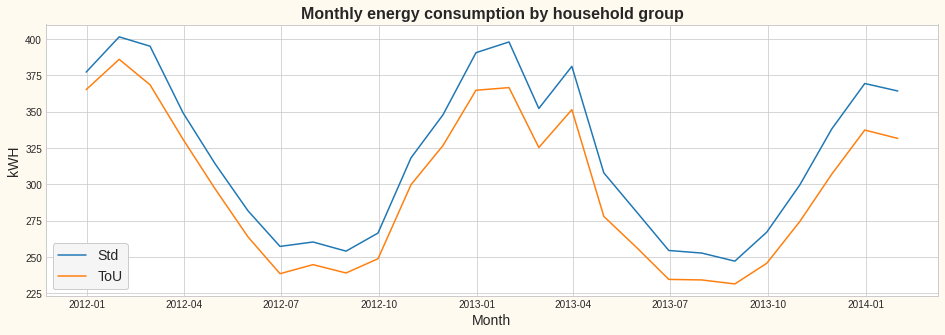

In [41]:
plt.figure(figsize=(16, 5), facecolor='floralwhite')
for tariff in daily_mean_by_tariff_type.columns.to_list():
    plt.plot(
        monthly_mean_by_tariff_type.index.values,
        monthly_mean_by_tariff_type[tariff],
        label = tariff
    )

plt.legend(loc='lower left', frameon=True, facecolor='whitesmoke', framealpha=1, fontsize=14)
plt.title(
    'Monthly energy consumption by household group',
    fontdict = {'fontsize' : 16, 'fontweight' : 'bold'}
)
plt.xlabel('Month', fontsize = 14)
plt.ylabel('kWH', fontsize = 14)

# Uncomment for a copy to display in results
# plt.savefig(fname='images/result1-no-dupes.png', bbox_inches='tight')

plt.show()

Le diagramme est plus clair et il y a une différence evidente entre les deux groupes.

Veuillez noter que le diagramme ne montre pas la consommation mensuelle moyenne. Il montre la somme des moyennes journalières pour chaque mois. Pour calculer les vraies moyennes mensuelles on aurait besoin d'exclure les données journalières pour chaque résidence pendant les mois où les données n'étaient pas complètes. Notre méthode plus simple devrait nous donner une bonne approximation.